# White noise fitting example (EFAC and EQUAD)

This notebook corresponds to Section 

In [ ]:
from enterprise.pulsar import Pulsar
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.signals.gp_signals import TimingModel
from enterprise.signals.signal_base import PTA
from enterprise.signals.parameter import Uniform, LinearExp
from enterprise.signals.selections import Selection, no_selection

from pint.models import get_model_and_toas
from pint.fitter import Fitter
from pint.logging import setup as setup_log
from pint.utils import akaike_information_criterion
from pint.output.publish import publish

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
setup_log(level="ERROR")

1

In [3]:
m, t = get_model_and_toas("simulations/sim1.par", "simulations/sim1.tim", planets=True)

In [4]:
print(m)

# Created: 2023-12-21T15:27:28.103039
# PINT_version: 0.9.6+759.gc52a766d
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.2.0-37-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                      5:00:00.00000000 1 0.00000000000000000000
DECJ                    15:00:00.00000000 1 0.00000000000000000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  100.0 1 0.0
F1                                 -1e-15 1 0.0
PEPOCH             55000.0000000000000000
TZRMJD     

In [5]:
result = np.zeros((2,2))
for eff in [True, False]:
    for eqf in [True, False]:
        m1 = deepcopy(m)
        m1.EFAC1.value = 1
        m1.EQUAD1.value = 1e-4
        m1.EFAC1.frozen = not eff
        m1.EQUAD1.frozen = not eqf

        ftr = Fitter.auto(t, m1)
        ftr.fit_toas(noise_fit_niter=5)

        fp = set(m1.free_params).intersection(["EFAC1", "EQUAD1"])
        
        result[int(not eff), int(not eqf)] = akaike_information_criterion(ftr.model, t)
        # print(ftr.model)
        # print(f"AIC = {np.round(aic)-ref}\t for EFAC={ftr.model.EFAC1.value}, EQUAD={ftr.model.EQUAD1.value}")
        # print()

In [6]:
np.round(result - np.min(result))

array([[   0.,  198.],
       [  44., 5191.]])

In [7]:
ftr = Fitter.auto(t, m)
ftr.fit_toas()

In [8]:
print(ftr.model)

# Created: 2023-12-21T15:27:42.445359
# PINT_version: 0.9.6+759.gc52a766d
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.2.0-37-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999567183797
FINISH             56985.0000000464162847
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   2000.0000000022656
CHI2R                  1.0045203415380541
TRES                2.4134591611789330881
RAJ                      4:59:59.99999598 1 0.00000275770694145185
DECJ                    15:00:00.00027474 1 0.00023540336077444333
PMRA                                  0.0
PMDEC                  

In [9]:
psr = Pulsar(ftr.model, t)

In [10]:
tm = TimingModel()
wn = MeasurementNoise(efac=Uniform(0.5, 2.0), log10_t2equad=LinearExp(-8, -4))

In [11]:
model = tm + wn

In [12]:
pta = PTA([model(psr)])

In [13]:
ndim = len(pta.param_names)
x0 = np.array([p.sample() for p in pta.params])
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/sim1/"
Niter = 100000

In [14]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [15]:
sampler.sample(
    x0,
    Niter,
)

Finished 10.00 percent in 6.662898 s Acceptance rate = 0.52184Adding DE jump with weight 20
Finished 99.00 percent in 59.913079 s Acceptance rate = 0.513414
Run Complete


In [16]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]
burned_chain[:, 1] = 10**burned_chain[:, 1] * 1e6

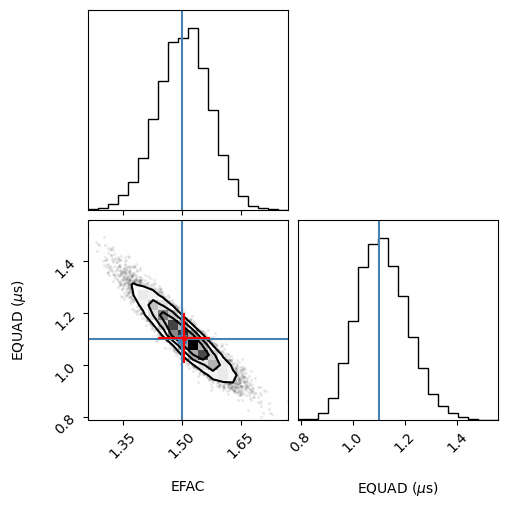

In [38]:
fig = corner.corner(
    burned_chain, 
    labels=["EFAC", "EQUAD ($\\mu$s)"], 
    truths=[m.EFAC1.value, m.EQUAD1.quantity.value],
)

plt.subplot(223)
plt.errorbar(
    [ftr.model.EFAC1.value], 
    [ftr.model.EQUAD1.value],
    xerr=[ftr.model.EFAC1.uncertainty_value], 
    yerr=[ftr.model.EQUAD1.uncertainty_value],
    color="red",
    marker="."
)

plt.savefig("sim1.pdf")

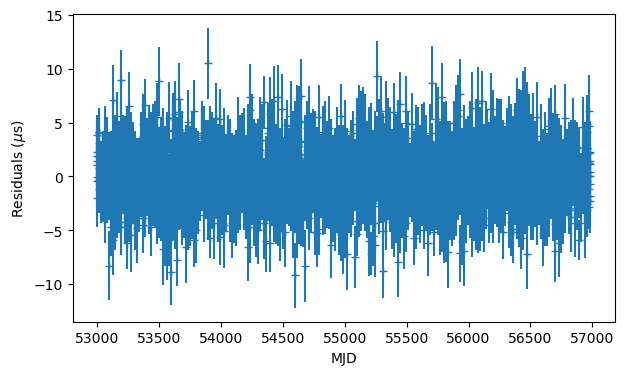

In [48]:
plt.figure(figsize=(7, 4))
plt.errorbar(ftr.toas.get_mjds(), ftr.resids.time_resids.to("us"), ftr.resids.get_data_error().to("us"), ls="", marker="+")
plt.ylabel("Residuals ($\\mu$s)")
plt.xlabel("MJD")
plt.savefig("sim1-resids.pdf")

Signature:
plt.figure(
    num: 'int | str | Figure | SubFigure | None' = None,
    figsize: 'tuple[float, float] | None' = None,
    dpi: 'float | None' = None,
    *,
    facecolor: 'ColorType | None' = None,
    edgecolor: 'ColorType | None' = None,
    frameon: 'bool' = True,
    FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>,
    clear: 'bool' = False,
    **kwargs,
) -> 'Figure'
Docstring:
Create a new figure, or activate an existing figure.

Parameters
----------
num : int or str or `.Figure` or `.SubFigure`, optional
    A unique identifier for the figure.

    If a figure with that identifier already exists, this figure is made
    active and returned. An integer refers to the ``Figure.number``
    attribute, a string refers to the figure label.

    If there is no figure with the identifier or *num* is not given, a new
    figure is created, made active and returned.  If *num* is an int, it
    will be used for the ``Figure.number`` attribute, otherwise, an
